# Yggdrax Getting Started\n
\n
This notebook demonstrates basic tree construction, geometry extraction, and interaction generation.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from yggdrax import DualTreeTraversalConfig, build_tree, compute_tree_geometry, build_interactions_and_neighbors
from yggdrax.tree_moments import compute_tree_mass_moments

In [2]:
key = jax.random.PRNGKey(7)
key_pos, key_mass = jax.random.split(key)
positions = jax.random.uniform(key_pos, (256, 3), minval=-1.0, maxval=1.0, dtype=jnp.float32)
masses = jax.random.uniform(key_mass, (256,), minval=0.5, maxval=1.5, dtype=jnp.float32)

In [3]:
tree = build_tree(positions, masses, leaf_size=16)
positions_sorted = positions[tree.particle_indices]
geometry = compute_tree_geometry(tree, positions_sorted)
traversal_cfg = DualTreeTraversalConfig(
    max_pair_queue=8192,
    process_block=256,
    max_interactions_per_node=2048,
    max_neighbors_per_leaf=2048,
)
interactions, neighbors = build_interactions_and_neighbors(
    tree,
    geometry,
    theta=0.8,
    mac_type='dehnen',
    traversal_config=traversal_cfg,
)

print('nodes:', int(tree.num_nodes))
print('leaves:', int(tree.num_leaves))
print('far-field pairs:', int(jnp.sum(interactions.counts)))
print('near-field pairs:', int(jnp.sum(neighbors.counts)))

nodes: 31
leaves: 16
far-field pairs: 4
near-field pairs: 236


## Autodiff With a Fixed Tree

Tree topology is discrete, so a common pattern is:
1. Build the tree once from current particle positions.
2. Differentiate a downstream smooth objective that uses that fixed topology.

In [8]:
def mass_moment_loss(masses_unsorted: jnp.ndarray) -> jnp.ndarray:
    masses_sorted = masses_unsorted[tree.particle_indices]
    moments = compute_tree_mass_moments(tree, positions_sorted, masses_sorted)
    target_mass = 1.0
    return jnp.mean((moments.mass - target_mass) ** 2)

loss_value = mass_moment_loss(masses)
grad_masses = jax.grad(mass_moment_loss)(masses)

print('loss:', float(loss_value))
print('grad shape:', tuple(grad_masses.shape))
print('grad norm:', float(jnp.linalg.norm(grad_masses)))

loss: 4149.9658203125
grad shape: (256,)
grad norm: 519.7321166992188


### How To Interpret The Autodiff Output

- `mass_moment_loss(...)` computes a scalar objective using per-node masses from `compute_tree_mass_moments`.
- In this example, each node mass is compared to a target value (`1.0`) and squared error is averaged over nodes.
- `jax.grad(mass_moment_loss)(masses)` returns the gradient of that scalar loss with respect to each particle mass.

What each printed value means:
- `loss`: Current objective value for the sampled masses. Lower is better for this toy target.
- `grad shape`: One gradient entry per particle mass (`(N,)`).
- `grad norm`: Overall gradient magnitude. A large value means the loss is sensitive to mass changes.

Important modeling note:
- The tree topology is treated as fixed in this differentiation step.
- This is the common pattern in JAX/FMM pipelines: rebuild tree when needed, then differentiate smooth downstream computations for optimization.

## Nearest Neighbors at a Fixed Distance (Tree Rebuilt Each Step)

This is a more intuitive autodiff demo inspired by nearest-neighbor style examples.

Idea:
- Rebuild the tree inside the objective.
- Use nearby particles in Morton order as local nearest-neighbor candidates.
- Penalize deviation from a target nearest-neighbor distance.

In [4]:
def morton_nn_stats(
    positions_unsorted: jnp.ndarray,
    target_distance: float = 0.12,
    k_neighbors: int = 8,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    def safe_norm(delta: jnp.ndarray) -> jnp.ndarray:
        return jnp.sqrt(jnp.sum(delta * delta, axis=1) + 1e-12)

    dynamic_tree = build_tree(positions_unsorted, masses, leaf_size=16)
    pos_sorted = positions_unsorted[dynamic_tree.particle_indices]
    n = pos_sorted.shape[0]
    idx = jnp.arange(n)
    big = jnp.asarray(1e6, dtype=pos_sorted.dtype)

    candidate_dists = []
    for off in range(1, k_neighbors + 1):
        idx_plus = jnp.clip(idx + off, 0, n - 1)
        idx_minus = jnp.clip(idx - off, 0, n - 1)
        dist_plus = safe_norm(pos_sorted - pos_sorted[idx_plus])
        dist_minus = safe_norm(pos_sorted - pos_sorted[idx_minus])
        valid_plus = idx + off < n
        valid_minus = idx - off >= 0
        candidate_dists.append(jnp.where(valid_plus, dist_plus, big))
        candidate_dists.append(jnp.where(valid_minus, dist_minus, big))

    nn_dist = jnp.min(jnp.stack(candidate_dists, axis=1), axis=1)
    loss = jnp.mean((nn_dist - target_distance) ** 2)
    return loss, nn_dist


def nn_distance_loss(positions_unsorted: jnp.ndarray) -> jnp.ndarray:
    loss, _ = morton_nn_stats(
        positions_unsorted,
        target_distance=0.12,
        k_neighbors=8,
    )
    return loss

initial_loss, initial_nn = morton_nn_stats(positions, target_distance=0.12, k_neighbors=8)
initial_grad = jax.grad(nn_distance_loss)(positions)

print('initial loss:', float(initial_loss))
print('mean NN distance:', float(jnp.mean(initial_nn)))
print('grad shape:', tuple(initial_grad.shape))
print('grad norm:', float(jnp.linalg.norm(initial_grad)))

initial loss: 0.015111171640455723
mean NN distance: 0.2072429060935974
grad shape: (256, 3)
grad norm: 0.024219563230872154


In [11]:
# JIT-compiled optimization step (after first-step warm-up this is faster).
loss_and_grad = jax.jit(jax.value_and_grad(nn_distance_loss))

positions_opt = positions
learning_rate = 0.75
num_steps = 100
topology_changes = 0
prev_signature = None
positions_history = [positions]
loss_history = []
mean_nn_history = []

for step in range(num_steps):
    loss_val, grad_val = loss_and_grad(positions_opt)
    positions_opt = jnp.clip(positions_opt - learning_rate * grad_val, -1.5, 1.5)
    positions_history.append(positions_opt)

    # Track descriptive metrics and ordering changes.
    loss_eval, nn_dist = morton_nn_stats(positions_opt, target_distance=0.12, k_neighbors=8)
    loss_history.append(float(loss_eval))
    mean_nn_history.append(float(jnp.mean(nn_dist)))

    tree_step = build_tree(positions_opt, masses, leaf_size=16)
    signature = tree_step.particle_indices[:16]
    if prev_signature is not None and not bool(jnp.all(signature == prev_signature)):
        topology_changes += 1
    prev_signature = signature

    if step % 20 == 0 or step == num_steps - 1:
        print(
            f'step={step:2d} | loss={float(loss_eval):.6f} | '
            f'mean_NN={float(jnp.mean(nn_dist)):.6f}'
        )

final_loss, final_nn = morton_nn_stats(positions_opt, target_distance=0.12, k_neighbors=8)
print('\nTarget distance:', 0.12)
print('Initial mean NN distance:', float(jnp.mean(initial_nn)))
print('Final mean NN distance:  ', float(jnp.mean(final_nn)))
print('Initial loss:', float(initial_loss))
print('Final loss:  ', float(final_loss))
print('Topology changes observed during optimization:', topology_changes)

step= 0 | loss=0.014675 | mean_NN=0.206087
step=20 | loss=0.008488 | mean_NN=0.186505
step=40 | loss=0.005445 | mean_NN=0.173401
step=60 | loss=0.004065 | mean_NN=0.165191
step=80 | loss=0.002876 | mean_NN=0.157826
step=99 | loss=0.002123 | mean_NN=0.152333

Target distance: 0.12
Initial mean NN distance: 0.2072429060935974
Final mean NN distance:   0.15233325958251953
Initial loss: 0.015111171640455723
Final loss:   0.0021227127872407436
Topology changes observed during optimization: 4


### Interpretation

- This objective is optimized with gradients w.r.t. particle positions, while the tree is rebuilt every step.
- If `mean_NN` moves toward the target and loss decreases, autodiff is doing useful work.
- `topology_changes > 0` indicates the discrete tree ordering changed during optimization; this is expected in dynamic-tree objectives.

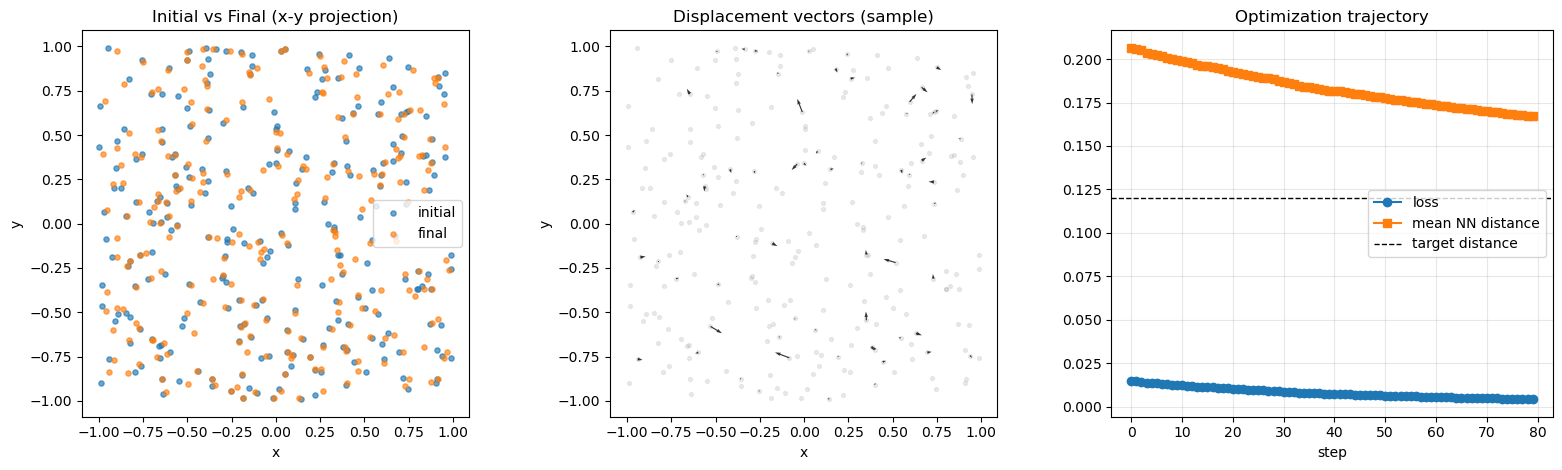

In [10]:
# Visual candy: initial/final distribution + displacement vectors + metric curves.
history = jnp.stack(positions_history)
pos_initial = history[0]
pos_final = history[-1]
disp = pos_final - pos_initial
sample = jnp.arange(min(64, pos_initial.shape[0]))

fig, axes = plt.subplots(1, 3, figsize=(16, 4.8))
axes[0].scatter(pos_initial[:, 0], pos_initial[:, 1], s=14, alpha=0.65, label='initial')
axes[0].scatter(pos_final[:, 0], pos_final[:, 1], s=14, alpha=0.65, label='final')
axes[0].set_title('Initial vs Final (x-y projection)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_aspect('equal', adjustable='box')
axes[0].legend(loc='best')

axes[1].scatter(pos_initial[:, 0], pos_initial[:, 1], s=8, alpha=0.15, color='0.5')
axes[1].quiver(
    pos_initial[sample, 0],
    pos_initial[sample, 1],
    disp[sample, 0],
    disp[sample, 1],
    angles='xy',
    scale_units='xy',
    scale=1.0,
    width=0.003,
    alpha=0.8,
)
axes[1].set_title('Displacement vectors (sample)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_aspect('equal', adjustable='box')

steps = jnp.arange(len(loss_history))
axes[2].plot(steps, loss_history, marker='o', label='loss')
axes[2].plot(steps, mean_nn_history, marker='s', label='mean NN distance')
axes[2].axhline(0.12, color='k', linestyle='--', linewidth=1.0, label='target distance')
axes[2].set_title('Optimization trajectory')
axes[2].set_xlabel('step')
axes[2].grid(alpha=0.3)
axes[2].legend(loc='best')

plt.tight_layout()
plt.show()